In [1]:
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K 
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt 
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_path='chest_xray/train'
val_path='chest_xray/val'
test_path='chest_xray/test'

In [3]:
train_batches=ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224), classes=['Normal','Pneumonia'],batch_size=16)
valid_batches=ImageDataGenerator().flow_from_directory(val_path,target_size=(224,224), classes=['Normal','Pneumonia'],batch_size=4)
test_batches=ImageDataGenerator().flow_from_directory(test_path,target_size=(224,224), classes=['Normal','Pneumonia'],batch_size=16)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [5]:
imgs, labels=next(train_batches)

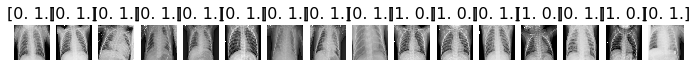

In [6]:
plots(imgs, titles=labels)

# Importing and fine-tuning the VGG16 model

In [7]:
vgg16_model= keras.applications.vgg16.VGG16()

In [8]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
vgg16_model.layers.pop()

In [10]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [11]:
model = Sequential()
for layers in vgg16_model.layers:
    model.add(layers)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
for layer in model.layers:
    layer.trainable=False

In [14]:
model.add(Dense(2, activation='softmax'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Training the VGG16 model

In [16]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
with tf.device("/device:GPU:0"):
    history = model.fit_generator(train_batches, epochs=5, steps_per_epoch=326,validation_data=valid_batches, validation_steps=16)

Epoch 1/5
326/326 [==============================] - 86s 265ms/step - loss: 0.2734 - acc: 0.8852 - val_loss: 0.3077 - val_acc: 0.8750
Epoch 2/5
326/326 [==============================] - 76s 233ms/step - loss: 0.1457 - acc: 0.9408 - val_loss: 0.4941 - val_acc: 0.7500
Epoch 3/5
326/326 [==============================] - 76s 232ms/step - loss: 0.1190 - acc: 0.9540 - val_loss: 0.3063 - val_acc: 0.8125
Epoch 4/5
326/326 [==============================] - 76s 234ms/step - loss: 0.1041 - acc: 0.9578 - val_loss: 0.2391 - val_acc: 0.8750
Epoch 5/5
326/326 [==============================] - 76s 234ms/step - loss: 0.0954 - acc: 0.9615 - val_loss: 0.1775 - val_acc: 0.8750


In [23]:
model.save('chestxray1.h5')


# Predict using the trained VGG16 model

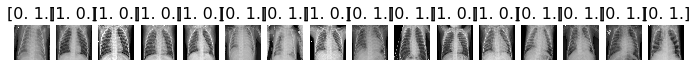

In [127]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [130]:
predictions = model.predict_generator(test_batches, 30)

In [131]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

ValueError: Found input variables with inconsistent numbers of samples: [2, 480]

In [111]:
def plot_confusion_matrix(cm,classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion amtrix, without normalization')
        
    print(cm)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

Confusion amtrix, without normalization
[[7 0]
 [0 9]]


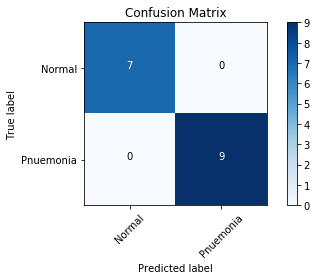

In [112]:
cm_plot_labels=['Normal','Pnuemonia']
plot_confusion_matrix(cm,cm_plot_labels,title='Confusion Matrix')